In [3]:
import math
import os
import pathlib
import random
from math import ceil, pi
import copy 

#import IPython
#import librosa    
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchaudio
from IPython.display import Audio
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
#from torch.utils.data import DataLoader, Dataset, IterableDataset
#from torchaudio.datasets import LIBRISPEECH, YESNO, SPEECHCOMMANDS
#from torchaudio.transforms import Spectrogram
from torch.nn.functional import kl_div
#import pytorch_lightning as pl


sns.set_style('white') #plt.style.use('seaborn-dark-palette')
pd.options.display.max_columns = None
pd.options.display.width = 250
mpl.rc('figure', figsize=(24, 16))
mpl.rc('font', size=30)
mpl.use("pgf")

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%load_ext autoreload
%autoreload 2
%matplotlib inline


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [4]:
class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-5

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This is correct only in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        sol = None 
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,j)] += torch.mul(vecs[i][k], vecs[j][k]).sum().data.cpu()
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,i)] += torch.mul(vecs[i][k], vecs[i][k]).sum().data.cpu()
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0   
                    for k in range(len(vecs[i])):
                        dps[(j, j)] += torch.mul(vecs[j][k], vecs[j][k]).sum().data.cpu()
                
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j), c, d]
                
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))
    
    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])
        
        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}

        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)
        
        
        n = len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]
    
        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]
                

        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec
        return sol_vec, nd

    def find_min_norm_element_FW(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            t_iter = np.argmin(np.dot(grad_mat, sol_vec))

            v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
            v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
            v2v2 = grad_mat[t_iter, t_iter]

            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec
            new_sol_vec[t_iter] += 1 - nc

            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec




In [5]:
from torch.autograd import Variable


def gradient_normalizers(grads, losses, normalization_type):
    gn = {}
    if normalization_type == 'l2':
        for t in grads:
            gn[t] = np.sqrt(np.sum([gr.pow(2).sum().data.cpu() for gr in grads[t]]))
    elif normalization_type == 'loss':
        for t in grads:
            gn[t] = losses[t]
    elif normalization_type == 'loss+':
        for t in grads:
            gn[t] = losses[t] * np.sqrt(np.sum([gr.pow(2).sum().data.cpu() for gr in grads[t]]))
    elif normalization_type == 'none':
        for t in grads:
            gn[t] = 1.0
    else:
        print('ERROR: Invalid Normalization Type')
    return gn


# Scaling the loss functions based on the algorithm choice
def scale_loss(mystft, alpha, epsilon, x, tasks):
    grads = {}
    loss_data = {}
    scale = {}
    #tasks = ['entropy', 'coverage', 'kurtosis']
    
    params = [ {'params': mystft.parameters()}]
    optimizer = torch.optim.RMSprop(params)
    
    # Compute gradients wrt to entropy 
    optimizer.zero_grad()
    spec, _ = mystft(x)
    dict_loss = mystft.loss(spec)
    '''
    alphat = mystft.strides[..., 1:] - (mystft.actual_win_length[..., 1:]-mystft.actual_win_length[..., 0:-1])/2   
    betat = alphat[:, 1:]+alphat[:, :-1]
    betat = torch.cat((2*alphat[:, 0:1], betat, 2*alphat[:, -1:]), dim=1) 
    weight = betat/betat.sum()
    weight = torch.ones_like(weight)
    weight = weight/weight.sum()'''
    
    alphat = mystft.actual_strides[None, 1:] #- (mystft.actual_win_length[..., 1:]-mystft.actual_win_length[..., 0:-1])/2       
    betat = alphat[:, 1:]+alphat[:, :-1]
    betat = torch.cat((2*alphat[:, 0:1], betat, 2*alphat[:, -1:]), dim=1) 
    weight = betat/betat.sum()
    
    entropy = (1- (dict_loss['div_js'] * weight).sum().mean())
    #print(entropy.data)  
    
    loss_data['entropy'] = entropy.data
    entropy.backward()
    
    grads['entropy'] = []
    for param in mystft.parameters():
        if param.grad is not None:
                grads['entropy'].append(Variable(param.grad.data.clone(), requires_grad=False))
    
    # Compute gradients wrt to coverage 
    optimizer.zero_grad()
    spec, _ = mystft(x)  
    dict_loss = mystft.loss(spec)
    cov = 1. * (1 - dict_loss['cov'].mean()-epsilon).pow(alpha)
    loss_data['coverage'] = cov.data
    cov.backward()
    
    grads['coverage'] = []
    for param in mystft.parameters():
        if param.grad is not None:
                grads['coverage'].append(Variable(param.grad.data.clone(), requires_grad=False))
                
                
    # Compute gradients wrt to kurtosis 
    optimizer.zero_grad()
    spec, _ = mystft(x)  
    dict_loss = mystft.loss(spec)
    #kur =  torch.exp( - 0.01 * dict_loss['kurtosis'].mean() )
    alphat = mystft.actual_strides[None, 1:] #- (mystft.actual_win_length[..., 1:]-mystft.actual_win_length[..., 0:-1])/2       
    betat = alphat[:, 1:]+alphat[:, :-1]
    betat = torch.cat((2*alphat[:, 0:1], betat, 2*alphat[:, -1:]), dim=1) 
    weight = betat/betat.sum()
    
    kur =  (weight /dict_loss['kurtosis']).mean() 
    
    #kur = 1 / dict_loss['kurtosis'].mean() 
    loss_data['kurtosis'] = kur.data
    kur.backward()
    
    grads['kurtosis'] = []
    for param in mystft.parameters():
        if param.grad is not None:
                grads['kurtosis'].append(Variable(param.grad.data.clone(), requires_grad=False))
                
        
    
    
    # Normalize all gradients 
    
    
    my_tasks = copy.deepcopy(tasks)
    removed_tasks = []
    my_grads = {}
    my_loss_data = {}
    
    
    for t in tasks:
        if (loss_data[t] <=1e-6):
            my_tasks.remove(t)
            removed_tasks.append(t)
        else:
            my_grads[t] = grads[t]
            my_loss_data[t] = loss_data[t]
    
    if len(my_tasks)>1:
        gn = gradient_normalizers(my_grads, my_loss_data, 'loss+')

        #print('norm', gn)

        for t in my_tasks:
            for gr_i in range(len(my_grads[t])):
                my_grads[t][gr_i] = my_grads[t][gr_i] / gn[t]

                
        # Frank-Wolfe iteration to compute scales.
        sol, min_norm =  MinNormSolver.find_min_norm_element([my_grads[t] for t in my_tasks])
    
        for i, t in enumerate(my_tasks):
            scale[t] = float(sol[i])
            
        
    else: # Only one task
        
        for i, t in enumerate(my_tasks):
            scale[t] = 1.0

    for i, t in enumerate(removed_tasks):
            scale[t] = 0.0
            
    return scale
        




In [6]:
sr = 1e3
tailles = [575, 1153, 635, 361, 1796, 1207]
freqs = [50, 228, 65, 171, 30, 144]
f = freqs[0] * (torch.ones(tailles[0]) + .01 * torch.rand(tailles[0]))
f = torch.cat((f, freqs[1]  * (torch.ones(tailles[1]) + .01 * torch.rand(tailles[1]))))
f = torch.cat((f, freqs[2]  * (torch.ones(tailles[2]) + .01 * torch.rand(tailles[2]))))
f = torch.cat((f, freqs[3]  * (torch.ones(tailles[3]) + .01 * torch.rand(tailles[3]))))
f = torch.cat((f, freqs[4]  * (torch.ones(tailles[4]) + .01 * torch.rand(tailles[4]))))
f = torch.cat((f, freqs[5]  * (torch.ones(tailles[5]) + .01 * torch.rand(tailles[5]))))

f = f + 0.*torch.ones_like(f)* torch.randn_like(f)


x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
x += 0.2 * torch.randn(x.shape)
x = x[None, :].to(device)

mark_list = np.cumsum(tailles).tolist()
mark_list.insert(0, 0)
print(mark_list)
#mark_list = [0, 400, 1500, 2100, 2400, 4200, 5199]

print(x.shape, x.device, x.dtype)

plt.figure(figsize=(12,8), constrained_layout=True)
plt.plot(f)
plt.xticks(mark_list)
plt.savefig('freq')
plt.show()


[0, 575, 1728, 2363, 2724, 4520, 5727]
torch.Size([1, 5727]) cuda:0 torch.float32


In [7]:
#sr = 1e3
#f = 100 * (torch.ones(700) + 0.1 * torch.rand(700))
##f = torch.cat((f, torch.linspace(100, 200, 300)))
#f = torch.cat((f, 200 * (torch.ones(700) + 0.1 * torch.rand(700))))
##f = torch.cat((f, torch.linspace(200, 50, 400)))
#f = torch.cat((f, 50 * (torch.ones(700) + 0.1 * torch.rand(700))))
##f = torch.cat((f, torch.linspace(50, 250, 100)))
#f = torch.cat((f, 250 * (torch.ones(700) + 0.1 * torch.rand(700))))
##f = torch.cat((f, torch.linspace(250, 50, 400)))
#f = torch.cat((f, 50 * (torch.ones(700) + 0.1 * torch.rand(700))))
##f = torch.cat((f, torch.linspace(50, 300, 200)))
#f = torch.cat((f, 300 * (torch.ones(700) + 0.1 * torch.rand(700))))
#
#
#
#f = f + 0.*torch.ones_like(f)* torch.randn_like(f)
#plt.plot(f)
#plt.show()
#
#x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
#
#x += 0.3 * torch.randn(x.shape)
#x = x[None, :].to(device)
#mark_list = [0, 700, 1400, 2100, 2800, 3500, 4199]
#
#print(x.shape, x.device, x.dtype)

In [8]:

class MySpec(nn.Module):
    def __init__(self, x, win_length: float, support: int, stride: float, pow: float = 1.0, requires_grad: bool = True, 
                    tapering_function: str = 'hann', dynamic_parameter : bool = False, window_transform=None, stride_transform=None):
        super(MySpec, self).__init__()
        
        # Constants and hyperparameters
        self.N = support                        # support size
        self.F = int(1 + self.N/2)              # nb of frequencies
        self.B = x.shape[0]                     # batch size
        self.L = x.shape[-1]                    # signal length
        self.device = x.device          
        self.dtype = x.dtype
        self.requires_grad = requires_grad      
        self.tapering_function = tapering_function
        self.dynamic_parameter = dynamic_parameter
        self.pow = pow
        self.tap_win = None
        #self.inf = 0
        #self.sup = self.L-self.N
        # Register eps and min as a buffer tensor
        self.register_buffer('eps', torch.tensor(torch.finfo(torch.float).eps, dtype=self.dtype, device=self.device))
        self.register_buffer('min', torch.tensor(torch.finfo(torch.float).min, dtype=self.dtype, device=self.device))
        # Definie number of frames 
        self.T = int(torch.div(self.L, stride, rounding_mode='floor'))       #int(1 + torch.div(self.L - (self.N - 1) - 1, stride, rounding_mode='floor'))      
        
        # Learnable parameters        
        #self.register_parameter('strides', nn.Parameter(torch.full((self.T,), abs(stride), dtype=self.dtype, device=self.device), requires_grad=self.requires_grad))

        
        if window_transform is None:
            self.window_transform = self.__window_transform
        else:
            self.window_transform = window_transform
        
        if stride_transform is None:
            self.stride_transform = self.__stride_transform
        else:
            self.stride_transform = stride_transform
        
        strides = torch.full((self.T,), abs(stride), dtype=self.dtype, device=self.device)
        strides[0] = 0
        self.strides = nn.Parameter(strides, requires_grad=self.requires_grad)  
        self.win_length = nn.Parameter(torch.full((1, self.T,), abs(win_length), dtype=self.dtype, device=self.device), requires_grad=self.requires_grad)
        
    def __window_transform(self, w):
        wout = torch.minimum(torch.maximum(w, self.N/20*torch.ones_like(w, device=self.device)), self.N*torch.ones_like(self.win_length, device=device))
        return wout
    
    def __stride_transform(self, s):
        sout = torch.minimum(torch.maximum(s, 0*torch.ones_like(s, device=device)), 2*self.N*torch.ones_like(s, device=device))
        sout[0] = s[0]
        return sout 
        
    @property 
    def actual_win_length(self):
        return self.window_transform(self.win_length)

    @property 
    def actual_strides(self):
        return self.stride_transform(self.strides)
    
        
    @property 
    def raw_strides(self):
        # Compute the strides between frames (support) 
        raw_strides = self.actual_strides + torch.cat((torch.tensor([self.N], dtype=self.dtype, device=self.device), self.actual_win_length.squeeze())).diff()/2
        return raw_strides
        
    @property
    def frames(self):
        # Compute the temporal position (indices) od frames (support)        
        frames = torch.cumsum(self.raw_strides, dim=0)   
        return frames
            
    def forward(self, x):
        # Compute the short-time Fourier transform of the input signal
        stft = self.stft(x, 'forward')
        spec = stft.abs().pow(self.pow)[:, :self.F]
        return spec + self.eps, stft 
    
    def backward(self, x, dl_ds):
        # Compute the gradient of the criteria with respect to learnable parameters
        dstft_dp = self.stft(x, 'backward')
        dl_dp = (torch.conj(dl_ds) * dstft_dp).sum().real
        return dl_dp.unsqueeze(0)
    
    def stft(self, x: torch.tensor, direction: str):
        # frames index
        idx_floor = self.frames.floor()       
        idx_frac = self.frames - idx_floor 
        idx_floor = idx_floor.long()[:, None].expand((self.T, self.N)) + torch.arange(0, self.N, device=self.device)
        idx_floor[idx_floor>=self.L] = -1
        strided_x = x[:, idx_floor]
        strided_x[:, idx_floor < 0 ] = 0 
        
        # Fourier coefficients 
        coeff = torch.arange(end=self.N, device=self.device, dtype=self.dtype)
        coeff = coeff[:, None] @ coeff[None, :]
        coeff = torch.exp(- 2j * pi * coeff / self.N)    
        
        self.tap_win = self.window_function(direction=direction, idx_frac=idx_frac).permute(2, 1, 0)
        
        strided_x = strided_x[:, :, None, :]
        
        self.tap_win = self.tap_win[None, :, :, :]
        
        
        coeff = coeff[None, None, :, :]        
        
        tapered_x = (strided_x * self.tap_win)[:, :, :, :, None]
        tapered_x = torch.view_as_complex(torch.cat((tapered_x, torch.zeros_like(tapered_x)), -1))
        
        stft = (tapered_x * coeff).sum(dim=-1)
        stft = stft.permute(0, 2, 1)
        
        return stft
        
    def window_function(self, direction: str, idx_frac) -> torch.tensor:
        
        valid_window_functions = {'hann', 'hanning', }
        if self.tapering_function not in valid_window_functions:
            raise ValueError(f"tapering_function must be one of '{valid_window_functions}', but got padding_mode='{self.tapering_function}'")
        else:
            base = torch.arange(0, self.N, 1, dtype=self.dtype, device=self.device)[:, None, None].expand([-1, self.N, self.T])    
            base = base - idx_frac
            self.expanded_win_length = self.actual_win_length[:, None, :].expand([self.N, self.N, self.T])
        
            self.tap_win = 0.5 - 0.5 * torch.cos(2 * pi * (base + (self.expanded_win_length-self.N+1)/2) / self.expanded_win_length )  
            
            
            if (base.shape[-1] == self.actual_win_length.shape[-1]) or self.actual_win_length.shape[-1] == 1:
                mask1 = base.ge(torch.ceil( (self.N-1+self.actual_win_length)/2))
                mask2 = base.le(torch.floor((self.N-1-self.actual_win_length)/2))            
            else:
                mask1 = base.ge(torch.ceil( (self.N-1+self.actual_win_length.permute(-1, -2))/2))
                mask2 = base.le(torch.floor((self.N-1-self.actual_win_length.permute(-1, -2))/2))
            self.tap_win[mask1] = 0
            self.tap_win[mask2] = 0
        
        self.tap_win = self.tap_win / self.tap_win.sum(dim=0, keepdim=True)
        
        
        return self.tap_win
        
    def loss(self, spec,):
        dict_loss = {}
        
        x = spec.permute(0, 2, 1) # B, T, F
        probs = torch.div(x.permute(0, 2, 1), x.sum(dim=-1)).permute(0, 2, 1) # B, T, F
        
        # compute divergence Jensen-Shannon between frame and uniform distribution       
        #p, q = probs, torch.full_like(probs, 1/self.F/np.log(2)) 
        #m = (p + q) / 2
        #div_pm = (p * (torch.clamp(torch.log(p), min=self.min) - torch.clamp(torch.log(m), min=self.min))).sum(dim=-1)
        #div_qm = (q * (torch.clamp(torch.log(q), min=self.min) - torch.clamp(torch.log(m), min=self.min))).sum(dim=-1)
        #div_js_u = (div_pm + div_qm) / 2 / np.log(2)
        #dict_loss['div_js_u'] = div_js_u.mean()
        
        #
        p, q = probs[:, 1:, :], probs[:, :-1, :]
        m = (p + q) / 2
        div_pm = (p * (torch.clamp(torch.log(p), min=self.min) - torch.clamp(torch.log(m), min=self.min))).sum(dim=-1)
        div_qm = (q * (torch.clamp(torch.log(q), min=self.min) - torch.clamp(torch.log(m), min=self.min))).sum(dim=-1)
        div_js_u = (div_pm + div_qm) / 2 / np.log(2)
        dict_loss['div_js'] = div_js_u.mean()
        
        
        # compute kurtosis
        #kur = (x - x.mean(dim=-1, keepdim=True)).pow(4).mean(dim=-1) / (x - x.mean(dim=-1, keepdim=True)).pow(2).mean(dim=-1).pow(2) # B, T
        kur = x.pow(4).mean(dim=-1) / x.pow(2).mean(dim=-1).pow(2) # B, T
        dict_loss['kurtosis'] = kur.mean()
        
        # compute coverage
        coverage = torch.minimum(self.actual_strides[1:], self.actual_win_length[..., 0:-1]) 
        coverage = torch.cat((coverage, self.actual_win_length[:, -1].unsqueeze(-1)), dim=1).squeeze()
        init = torch.minimum(torch.maximum(torch.zeros_like(self.frames), self.frames+self.N/2-self.actual_win_length[0]/2), self.L*torch.ones_like(self.frames))
        end = torch.maximum(torch.minimum(self.L*torch.ones_like(self.frames), self.frames+self.N/2+ torch.minimum( self.actual_win_length[0]/2, - self.actual_win_length[0]/2+coverage )), torch.zeros_like(self.frames))
        
        cov = torch.sum(end-init) / self.L
        dict_loss['cov'] = cov
        
        
        return dict_loss
    
    def print(self, spec, loss=None, marklist=None):
        fig = plt.figure(constrained_layout=True, figsize=(18, 7))
        gs = GridSpec(1, 2, figure=fig)
        
        if loss is not None:
            title = ""
            for key, value in loss.items():
                #print(key, value)
                title += f' {key} {value:.2f} - '
            plt.suptitle(title)
        
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        
        # Plotting the log-spectrogram
        ax1.imshow(spec[0].log().detach().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0, spec.shape[-1], 0, 1])
        ax2.plot([0, self.L], [self.T, self.T], linewidth=3, c='k')
        if marklist is not None:
            for elem in marklist:
                ax2.axvline(elem, 0, self.T, c='r')
        for i, (start, length) in enumerate(zip(self.frames.detach().cpu(), self.actual_win_length[0].detach().cpu())):
            #ax2.plot([start+self.N/2-length/2, start+self.N/2+length/2], [self.T-i-1, self.T-i-1], c='r')   
            #ax2.plot([start, start+self.N], [self.T-i-1.3, self.T-i-1.3], c='k')    
            if self.tap_win is not None:
                #ax2.plot(range(int((start+self.N/2-length/2).floor().item()), int((start+self.N/2+length/2).floor().item())), self.T-i-1.3+ 150 * self.tap_win[int((self.N/2-length/2).floor().item()):int((self.N/2+length/2).floor().item()), 0, i].squeeze().detach().cpu())
                ax2.plot(range(int(start.floor().item()), int(start.floor().item()+self.N)), self.T-i-1.3+ 150 * self.tap_win[:, i, 0].squeeze().detach().cpu())
            #ax2.plot(range(start, start+self.N), self.T-i-1 + self.tap_win[0, :, i])   
            #ax2.plot(range(start, start+self.N), self.T-i-1 - self.tap_win[:, 0, i])   
        
        
        plt.show()        
        return
    
    def print2(self, spec, loss=None, marklist=None, x=None, epoch=None):
        if epoch is None: epoch = 0
        indices = (self.frames.diff() > 200).nonzero()    
        indices = (1 + indices.squeeze()).tolist()
        indices.insert(0, 0)
        print(self.frames.diff(), '\n', indices)
        #print(self.frames + self.N/2)
        #print(self.actual_win_length)
        #spec2 = spec[..., indices]        
        ticks = torch.arange(200, 200+self.L, self.L/len(indices))
        labels = (self.frames.detach().cpu().numpy() + self.N/2).astype(int)
        
        
        fig, ax = plt.subplots()
        if x is not None:
            ax.plot(self.T + .5 + .5 * x.squeeze().cpu().numpy(), linewidth=1,)
        else:
            ax.plot([0, self.L], [self.T, self.T], linewidth=3)
        ax.set_xticks(labels[indices])
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        
        #print('xticks', plt.get_xticklabels())
        #print(self.frames.cpu().detach() + self.N/2)
        
        if marklist is not None:
            for elem in marklist:
                plt.axvline(elem, 0, self.T, c='gray')
        for i, (start, length) in enumerate(zip(self.frames.detach().cpu(), self.actual_win_length[0].detach().cpu())):
            #ax2.plot([start+self.N/2-length/2, start+self.N/2+length/2], [self.T-i-1, self.T-i-1], c='r')   
            #ax2.plot([start, start+self.N], [self.T-i-1.3, self.T-i-1.3], c='k')    
            if self.tap_win is not None:
                #ax2.plot(range(int((start+self.N/2-length/2).floor().item()), int((start+self.N/2+length/2).floor().item())), self.T-i-1.3+ 150 * self.tap_win[int((self.N/2-length/2).floor().item()):int((self.N/2+length/2).floor().item()), 0, i].squeeze().detach().cpu())
                ax.plot(range(int(start.floor().item()), int(start.floor().item()+self.N)), self.T-i-1.3+ 150 * self.tap_win[:, i, 0].squeeze().detach().cpu(), c='#1f77b4')
        ax.set_xlabel('time', fontsize=40)
        plt.savefig(f'frames_{epoch}')
        plt.show() 
                
        
        fig, ax = plt.subplots()
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ticks = torch.arange(200, 200+self.L, self.L/self.T)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=45)
        ax.imshow(spec[0].log().detach().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0, self.L, 0, .5])
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.set_ylabel('Frequencies', fontsize=40)
        ax.set_xlabel('Frames and their temporal positions', fontsize=40)
        plt.savefig(f'spec_{epoch}')
        plt.show()  
        
        
        fig, ax = plt.subplots()
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ticks = torch.arange(200, 200+self.L, self.L/self.T)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=45)
        ax.imshow(spec[0].log().detach().cpu(), aspect='auto', origin='lower', cmap='viridis', extent=[0, self.L, 0, .5])
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.set_ylabel('Frequencies', fontsize=40)
        ax.set_xlabel('Frames and their temporal positions', fontsize=40)
        plt.savefig(f'spec3_{epoch}')
        plt.show() 
        
        #fig, ax = plt.subplots(constrained_layout=True)
        #fig.set_figheight(8)
        #fig.set_figwidth(12)
        #ticks = torch.arange(200, 200+self.L, self.L/len(indices))
        #ax.set_xticks(ticks)
        #ax.set_xticklabels(labels[indices])
        #ax.imshow(spec2[0].log().detach().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0, self.L, 0, .5])
        ##ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        #plt.savefig(f'spec_{epoch}')
        #plt.show()   
        
        #indices = indices.insert(0, 0)
        #gs = GridSpec(1, 2, figure=fig)
        #
        #if loss is not None:
        #    title = ""
        #    for key, value in loss.items():
        #        #print(key, value)
        #        title += f' {key} {value:.2f} - '
        #    plt.suptitle(title)
        #
        #ax1 = fig.add_subplot(gs[0])
        #ax2 = fig.add_subplot(gs[1])
        #
        ## Plotting the log-spectrogram
        #ax1.imshow(spec[0].log().detach().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0, spec.shape[-1], 0, 1])
        #ax2.plot([0, self.L], [self.T, self.T], linewidth=3, c='k')
        #if marklist is not None:
        #    for elem in marklist:
        #        ax2.axvline(elem, 0, self.T, c='r')
        #for i, (start, length) in enumerate(zip(self.frames.detach().cpu(), self.actual_win_length[0].detach().cpu())):
        #    #ax2.plot([start+self.N/2-length/2, start+self.N/2+length/2], [self.T-i-1, self.T-i-1], c='r')   
        #    #ax2.plot([start, start+self.N], [self.T-i-1.3, self.T-i-1.3], c='k')    
        #    if self.tap_win is not None:
        #        #ax2.plot(range(int((start+self.N/2-length/2).floor().item()), int((start+self.N/2+length/2).floor().item())), self.T-i-1.3+ 150 * self.tap_win[int((self.N/2-length/2).floor().item()):int((self.N/2+length/2).floor().item()), 0, i].squeeze().detach().cpu())
        #        ax2.plot(range(int(start.floor().item()), int(start.floor().item()+self.N)), self.T-i-1.3+ 150 * self.tap_win[:, 0, i].squeeze().detach().cpu())
        #    #ax2.plot(range(start, start+self.N), self.T-i-1 + self.tap_win[0, :, i])   
        #    #ax2.plot(range(start, start+self.N), self.T-i-1 - self.tap_win[:, 0, i])   
        
        return

tensor([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250.], device='cuda:0',
       grad_fn=<SubBackward0>) 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


Epoch 0;	 Err 0.05;	 Kur 51.386;	 Cov 0.00;	 Scales {'kurtosis': 1.0, 'coverage': 0.0, 'entropy': 0.0} 
tensor([242.0107, 257.9881, 253.9868, 253.9913, 253.9886, 253.9860, 246.0122,
        242.0168, 257.9906, 253.9185, 246.0045, 246.0054, 246.0042, 246.0039,
        246.0044, 246.0054, 242.0166, 250.0181, 246.0134, 246.0283, 246.1792],
       device='cuda:0', grad_fn=<SubBackward0>) 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


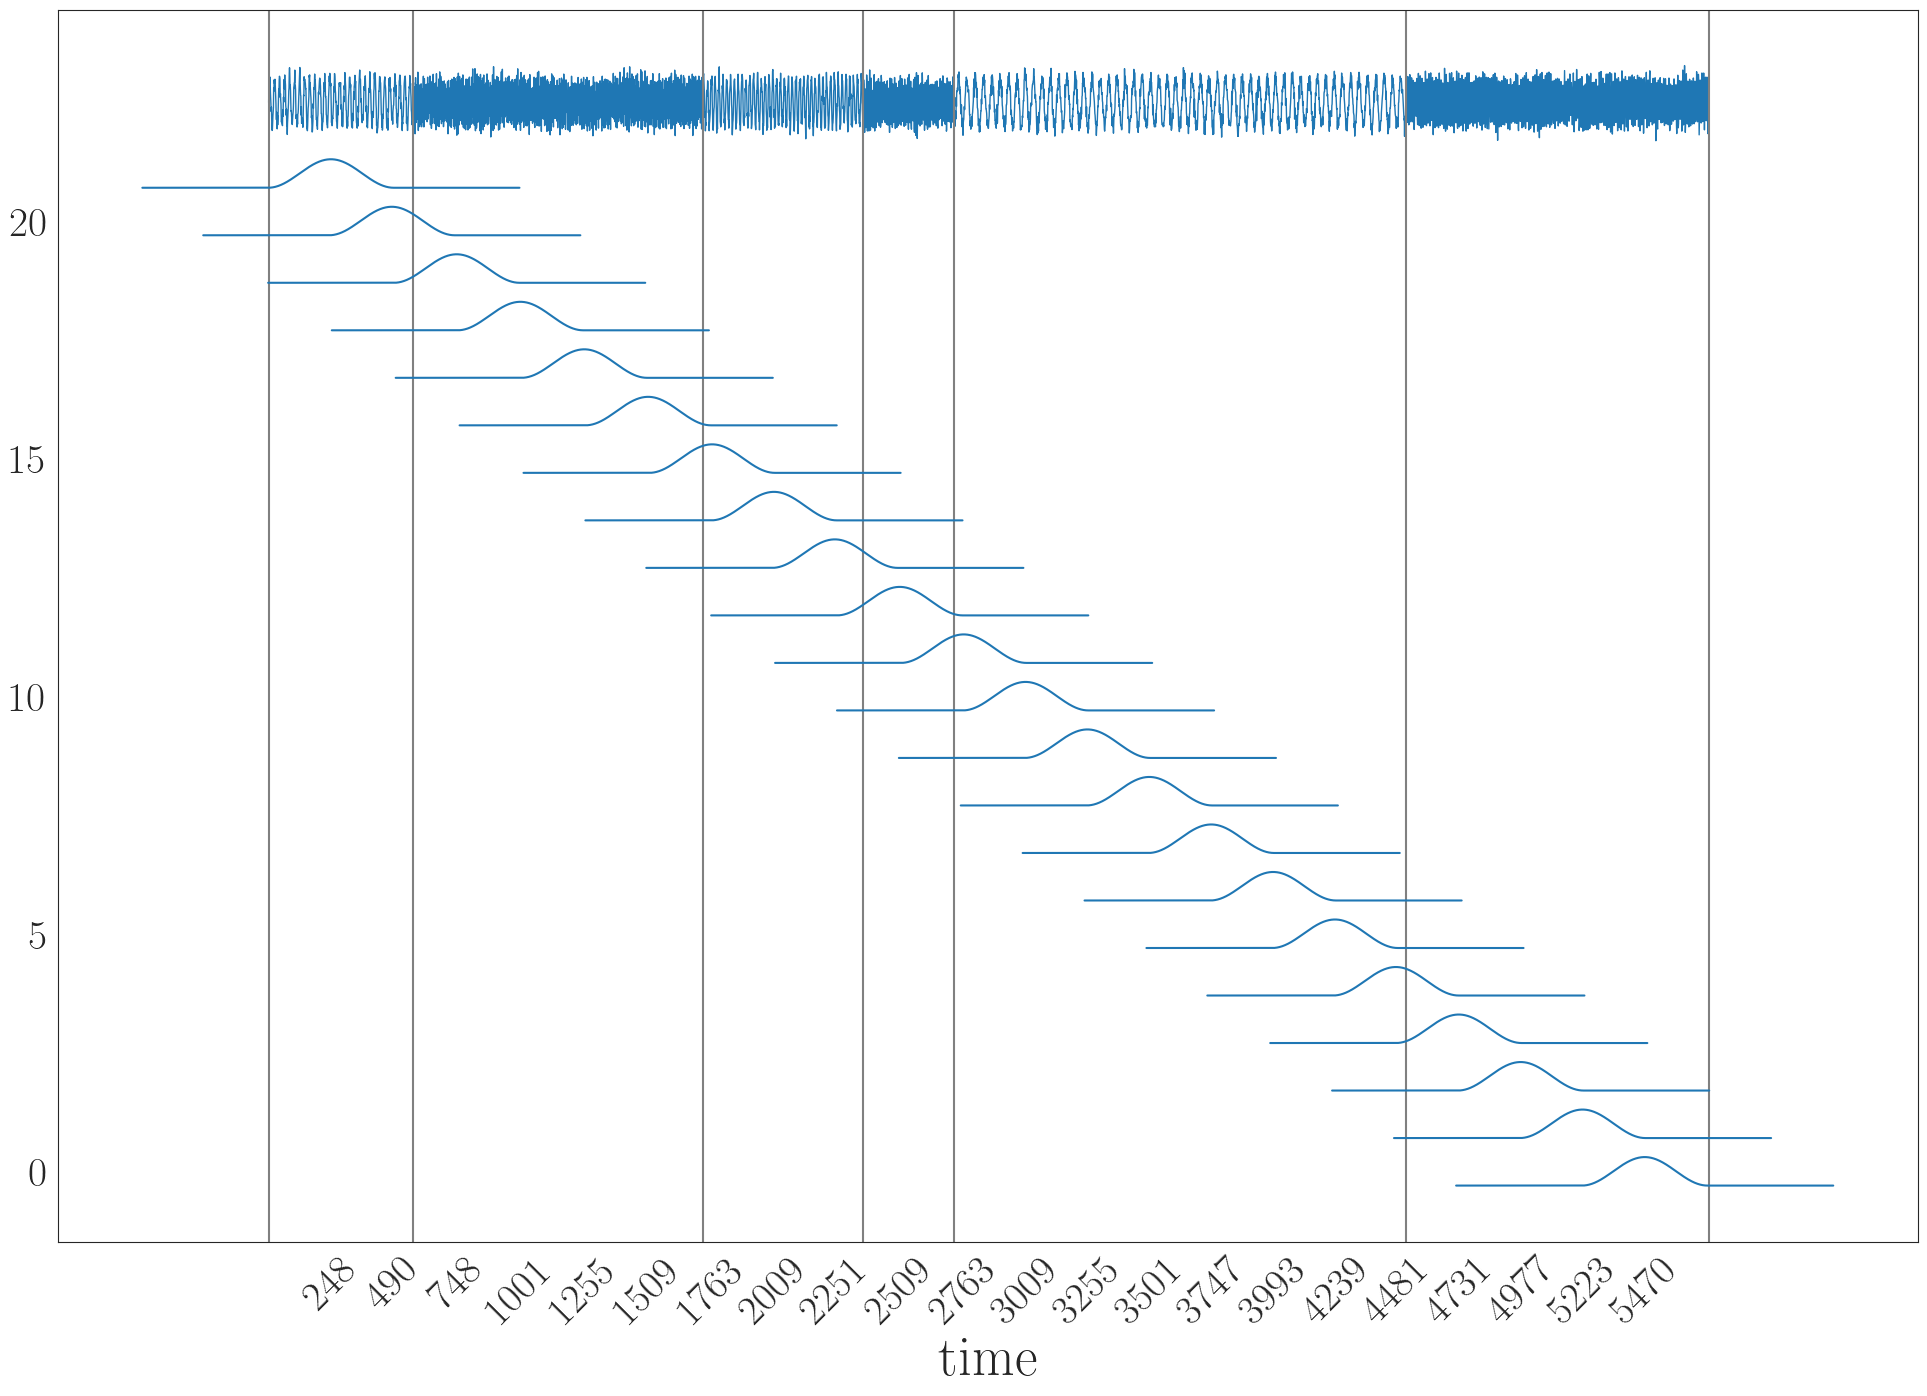

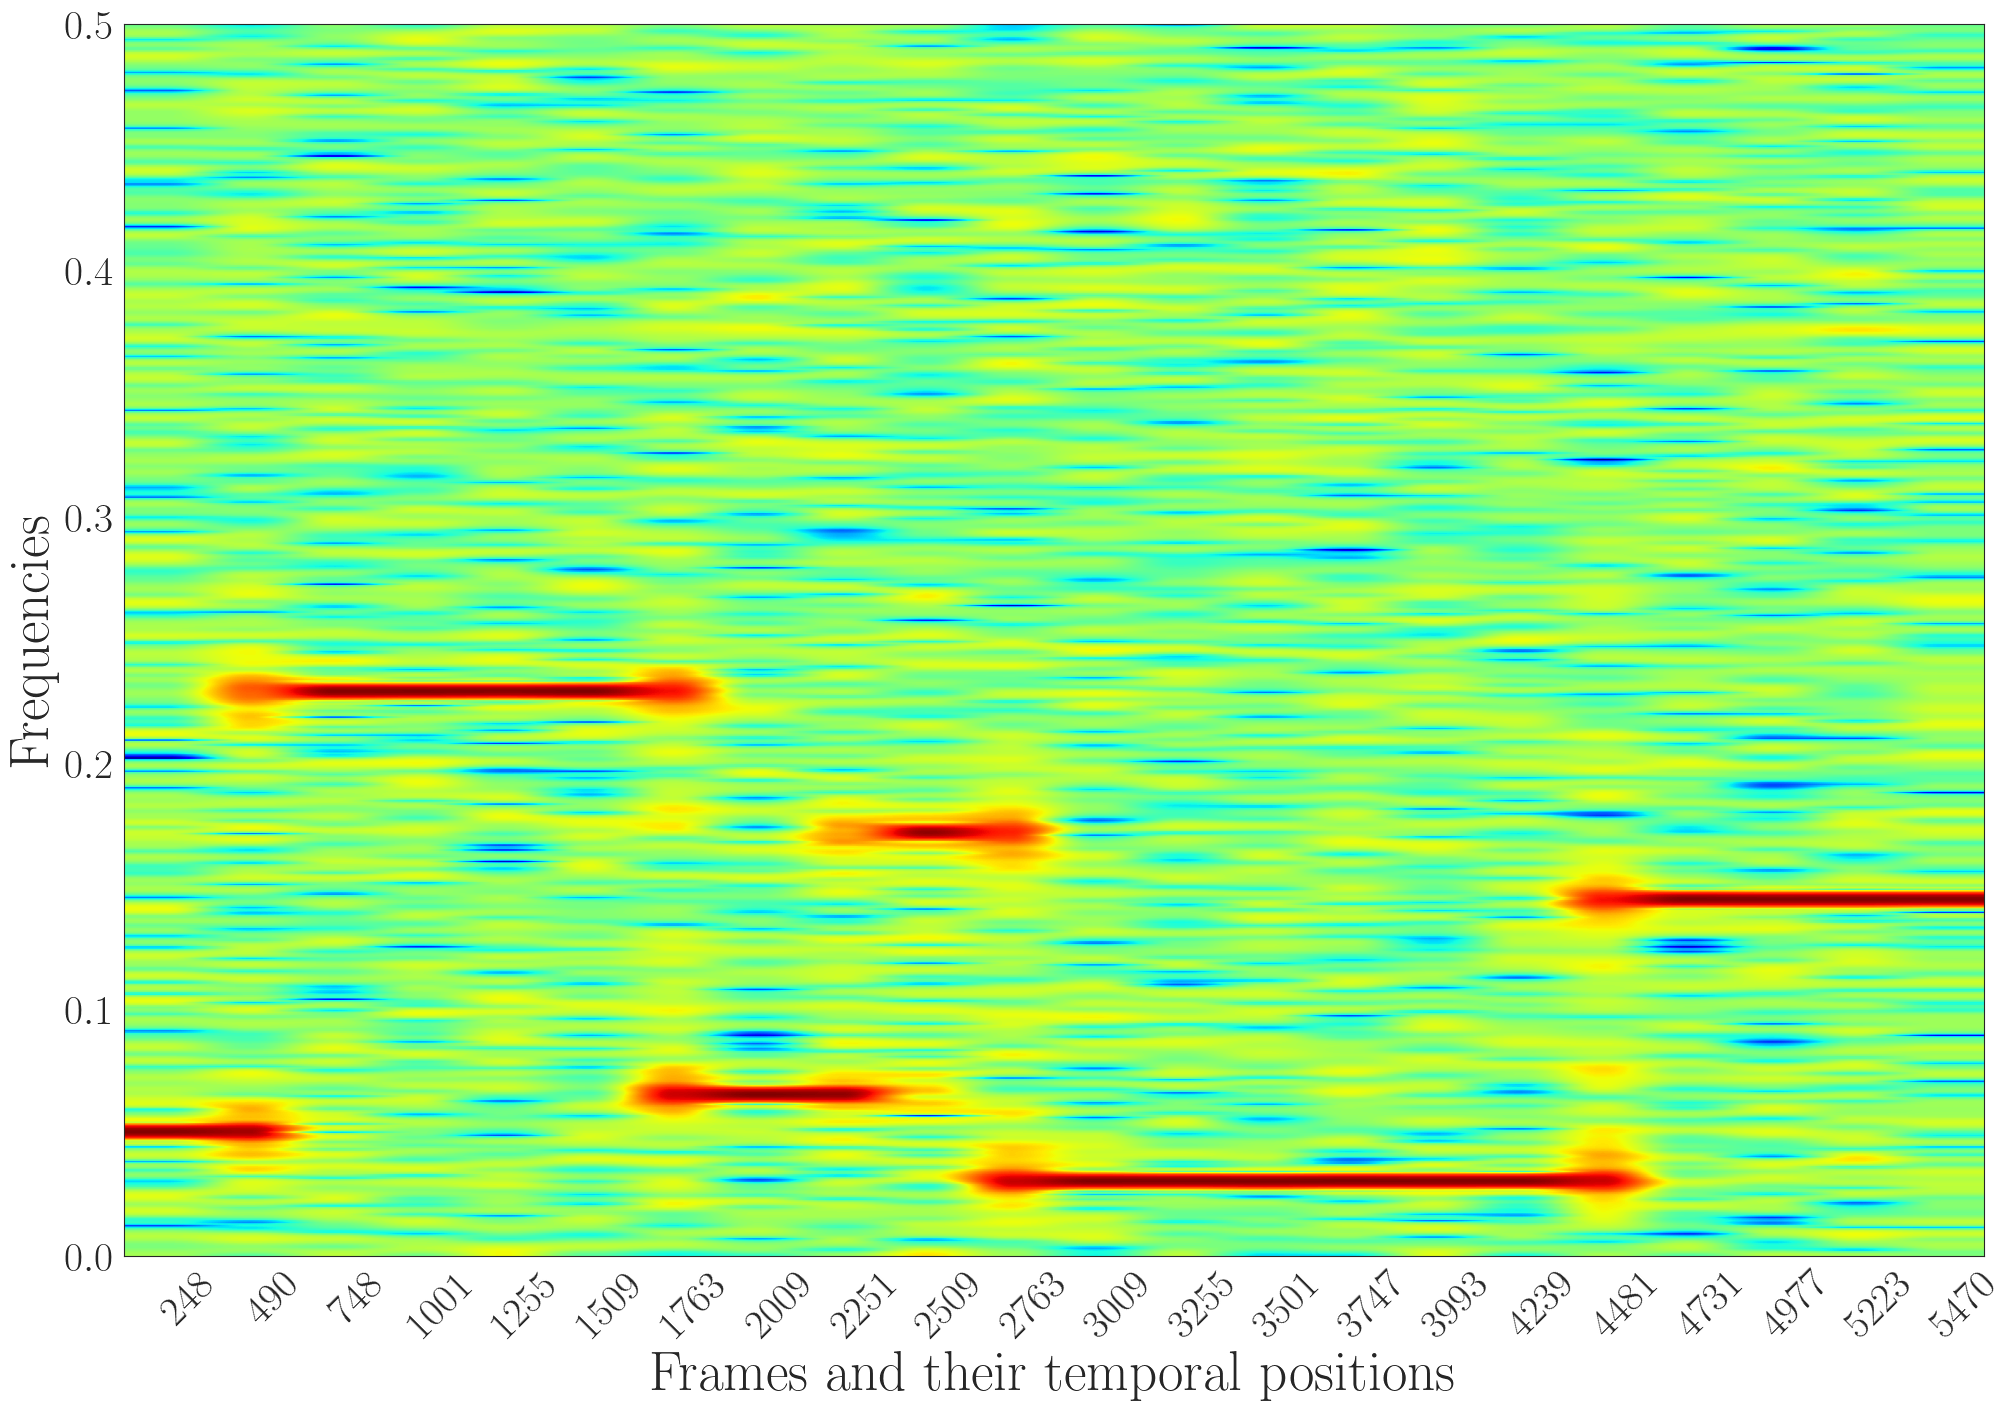

Epoch 100;	 Err 0.00;	 Kur 44.085;	 Cov 0.01;	 Scales {'kurtosis': 0.0011987657053396106, 'coverage': 0.9988012313842773, 'entropy': 0.0} 
tensor([186.5746, 313.9748, 276.7366, 278.5667, 275.5839, 289.5197, 208.0306,
        177.3248, 311.2229, 342.1611, 218.1455, 218.4385, 218.7275, 218.8291,
        218.8647, 219.0034, 183.1128, 289.3796, 222.6558, 226.2549, 249.6118],
       device='cuda:0', grad_fn=<SubBackward0>) 
 [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21]


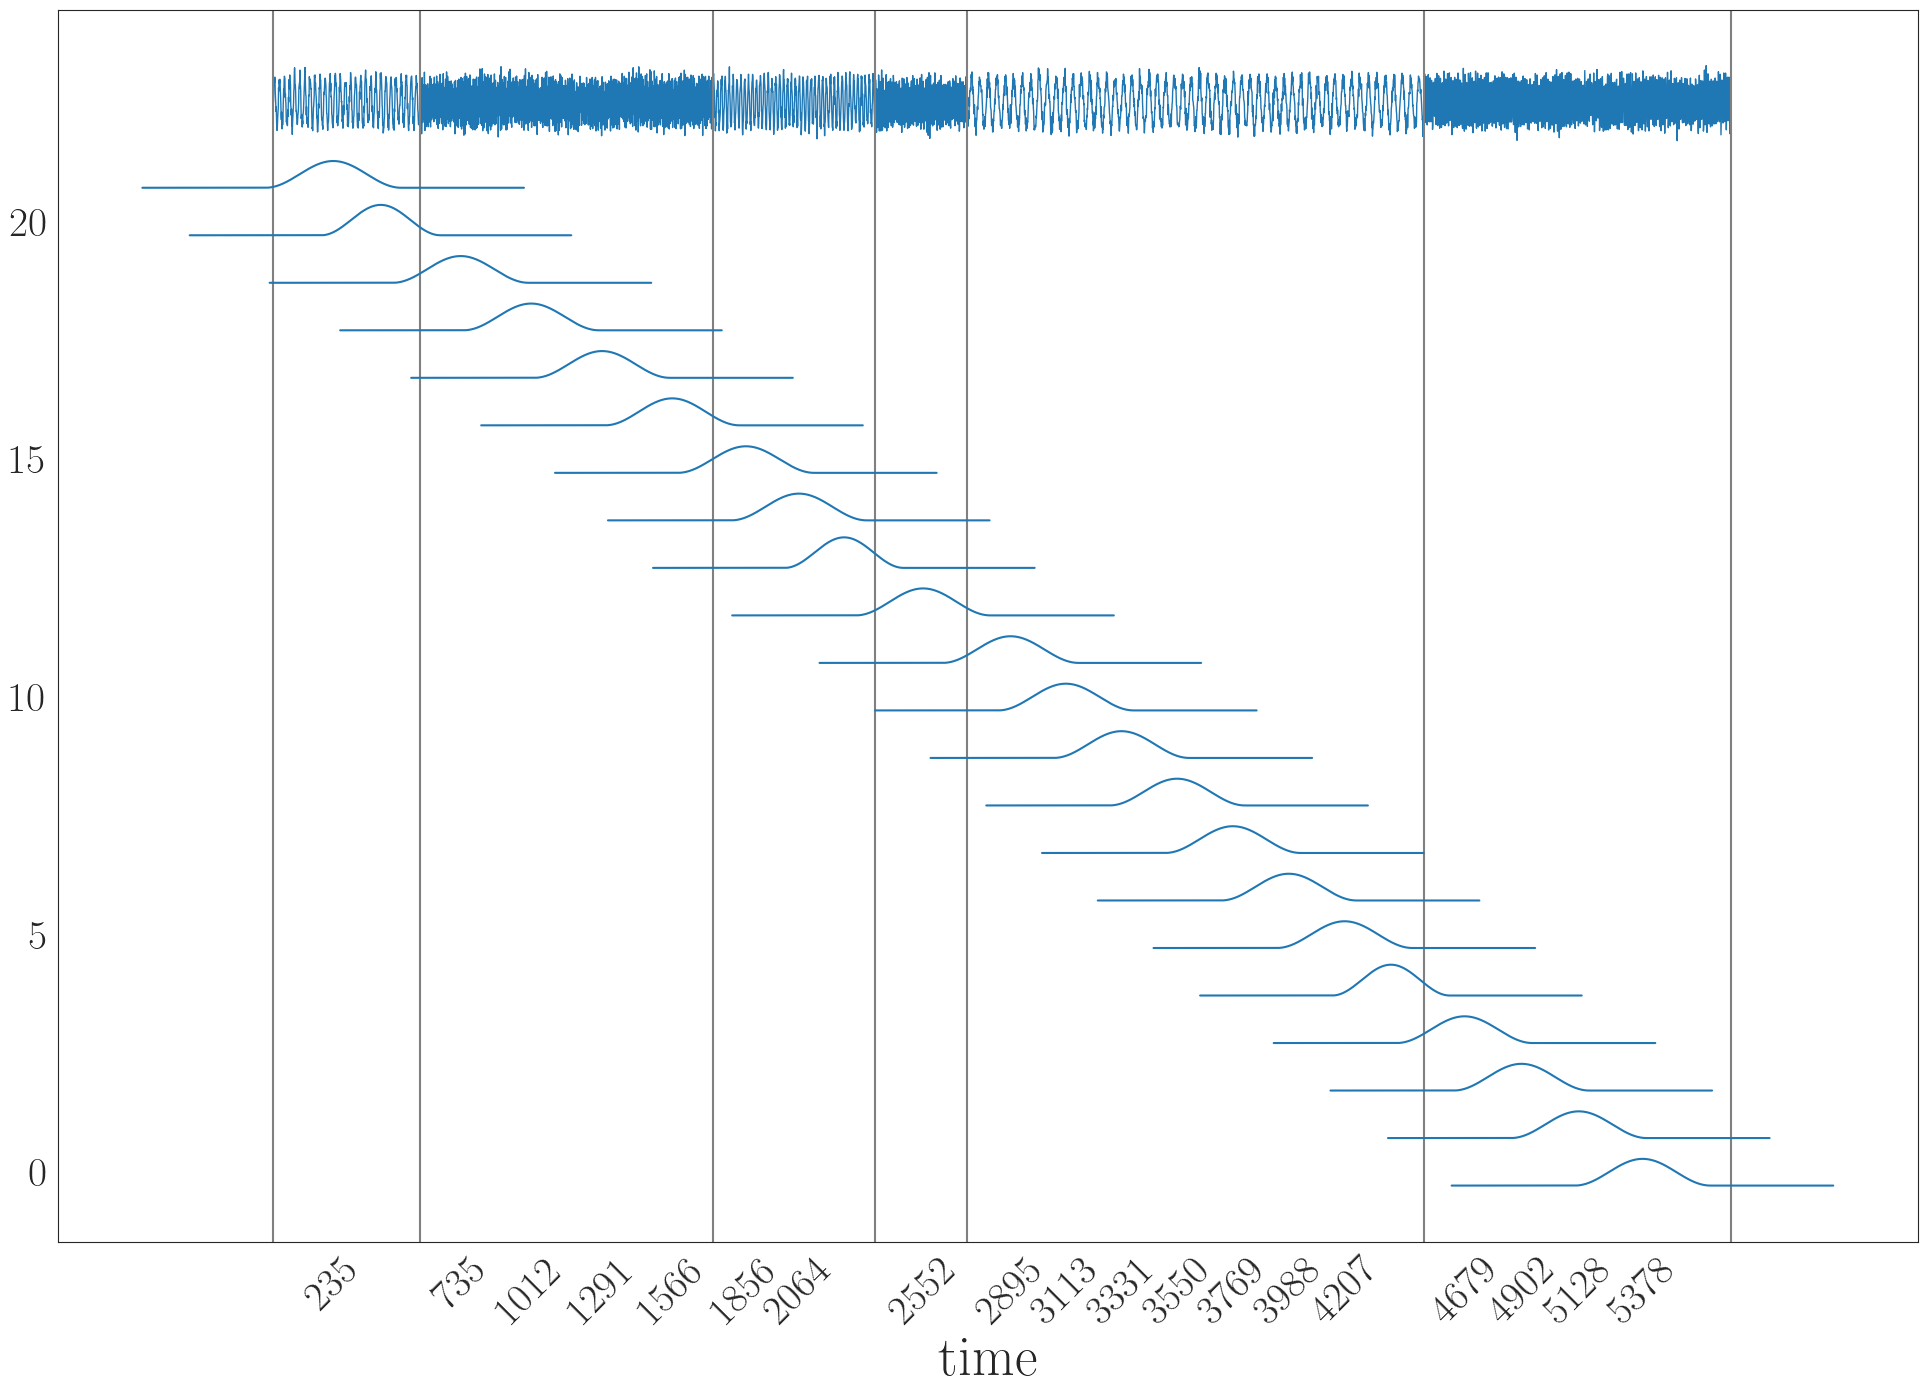

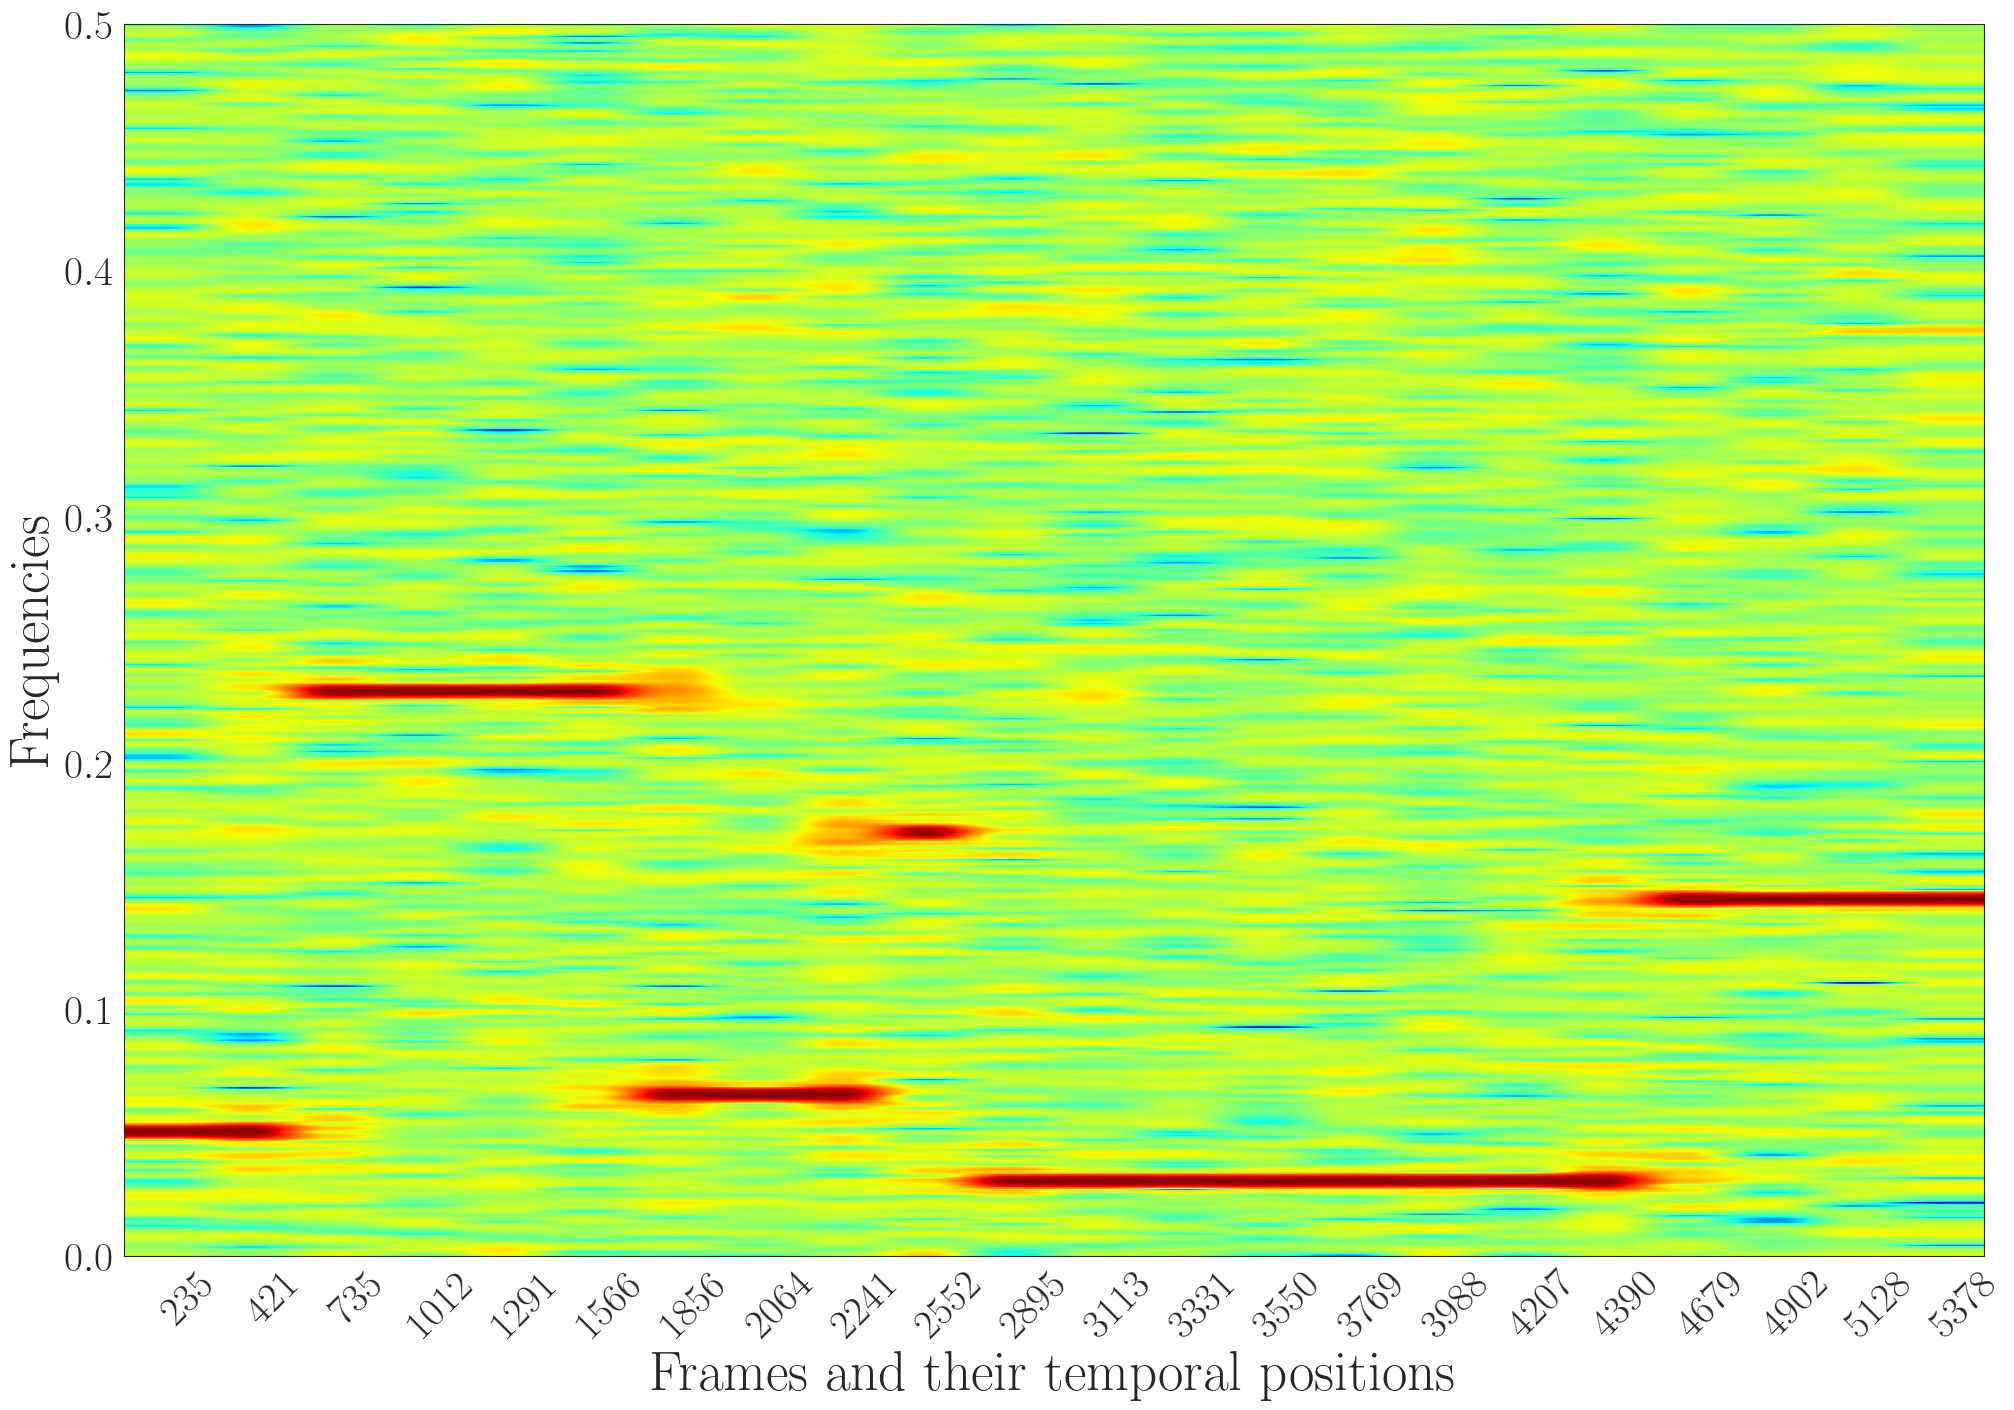

Epoch 200;	 Err 0.03;	 Kur 27.400;	 Cov 0.00;	 Scales {'kurtosis': 1.0, 'coverage': 0.0, 'entropy': 0.0} 
Epoch 300;	 Err 0.00;	 Kur 21.959;	 Cov 0.00;	 Scales {'kurtosis': 0.08260834962129593, 'coverage': 0.9173916578292847, 'entropy': 0.0} 
Epoch 400;	 Err 0.00;	 Kur 21.712;	 Cov 0.00;	 Scales {'kurtosis': 0.014863747172057629, 'coverage': 0.9851362705230713, 'entropy': 0.0} 
Epoch 500;	 Err 0.00;	 Kur 21.629;	 Cov 0.00;	 Scales {'kurtosis': 0.008681857958436012, 'coverage': 0.9913181662559509, 'entropy': 0.0} 
Epoch 600;	 Err 0.00;	 Kur 21.570;	 Cov 0.00;	 Scales {'kurtosis': 0.005892687942832708, 'coverage': 0.9941073060035706, 'entropy': 0.0} 
Epoch 700;	 Err 0.00;	 Kur 21.522;	 Cov 0.00;	 Scales {'kurtosis': 0.004982036538422108, 'coverage': 0.995017945766449, 'entropy': 0.0} 
Epoch 800;	 Err 0.00;	 Kur 21.478;	 Cov 0.00;	 Scales {'kurtosis': 0.003970558289438486, 'coverage': 0.9960294365882874, 'entropy': 0.0} 
Epoch 900;	 Err 0.00;	 Kur 21.440;	 Cov 0.00;	 Scales {'kurtosis': 0

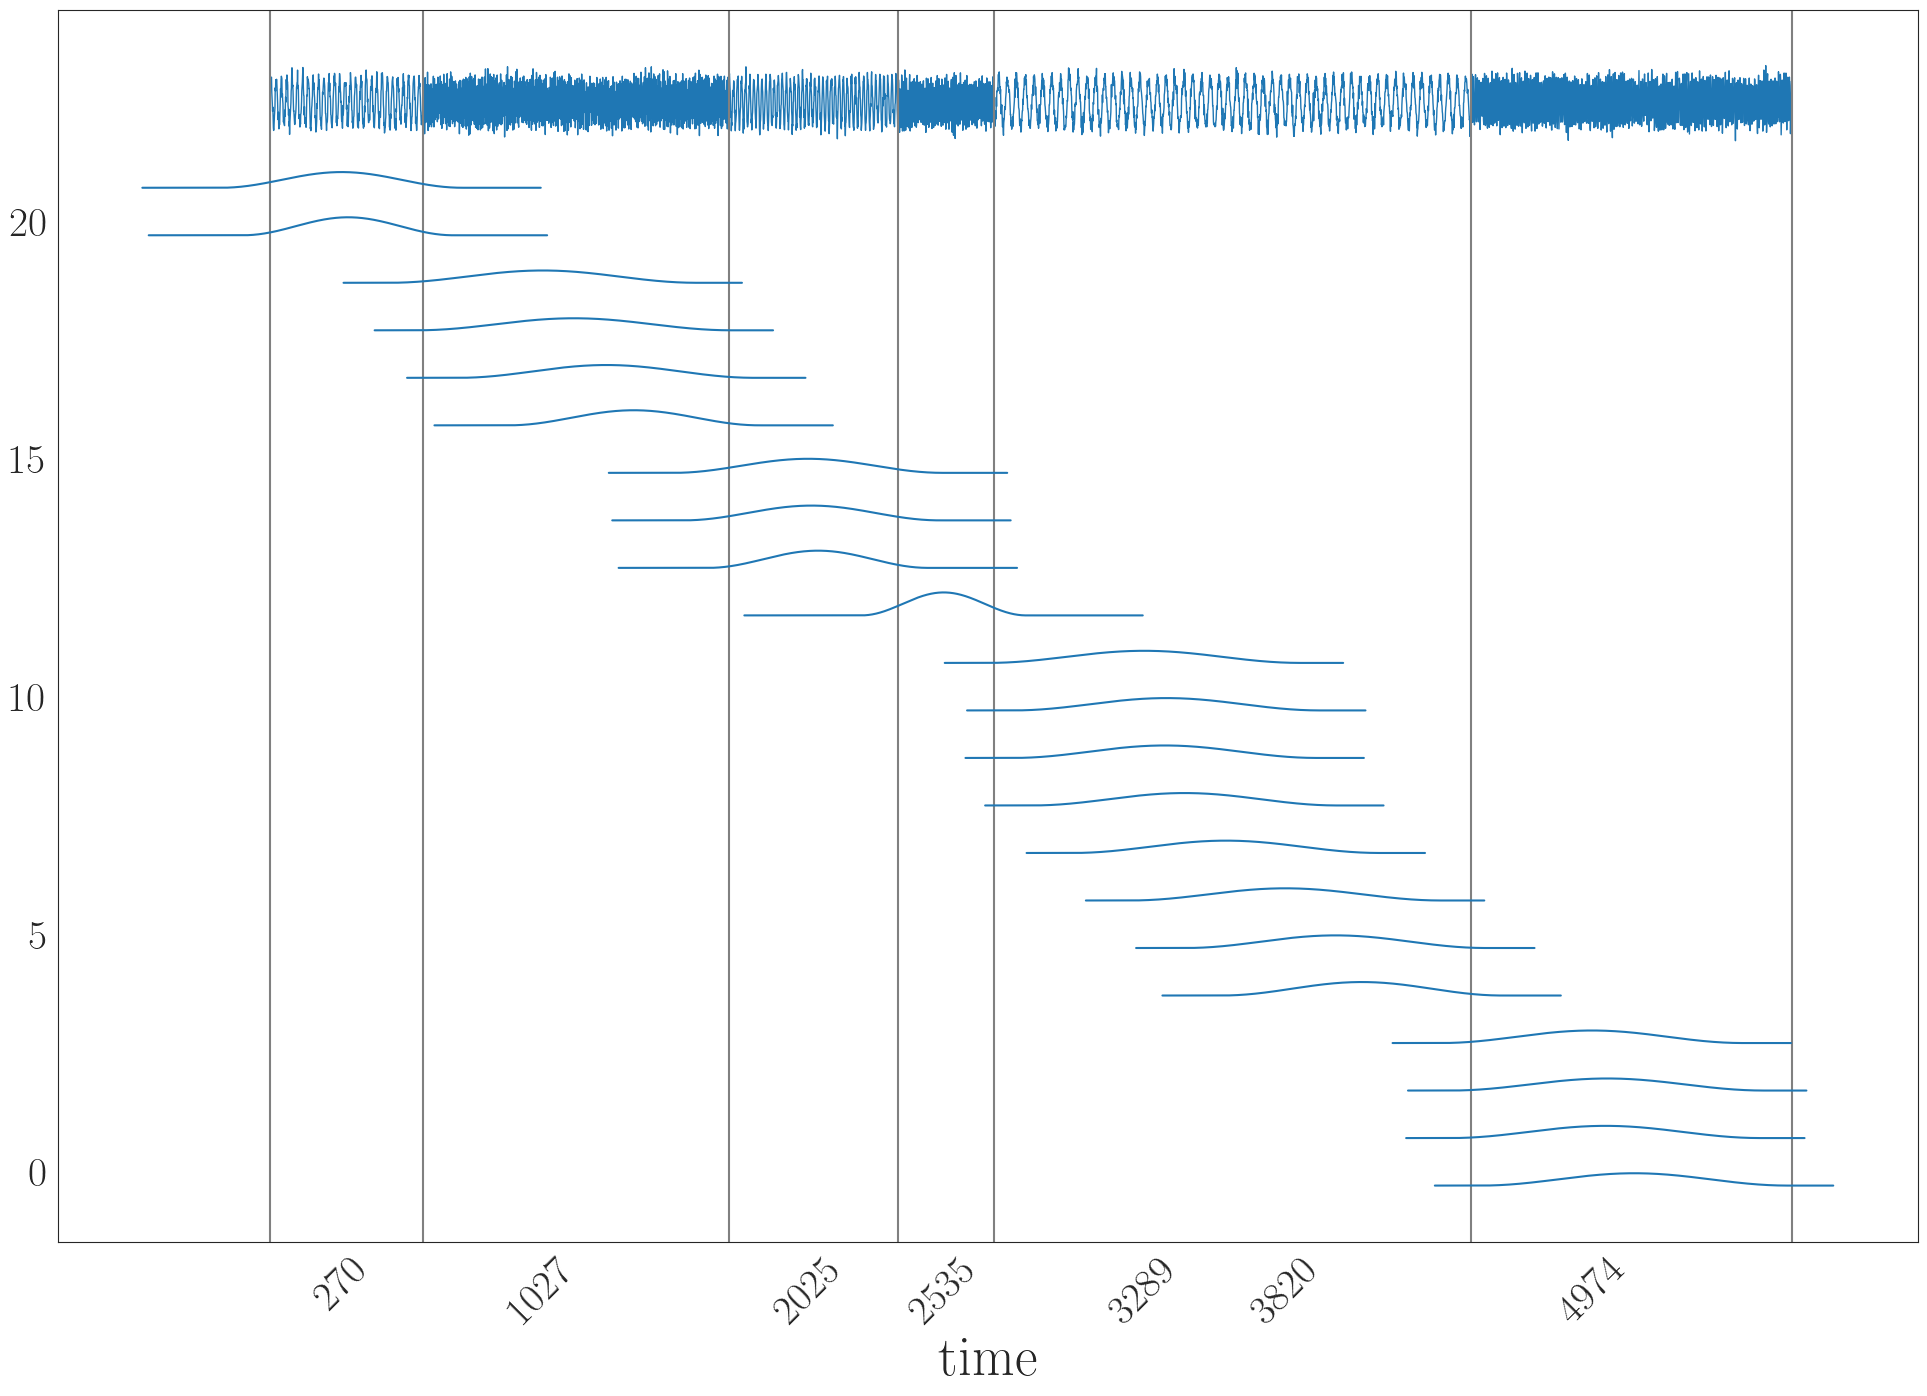

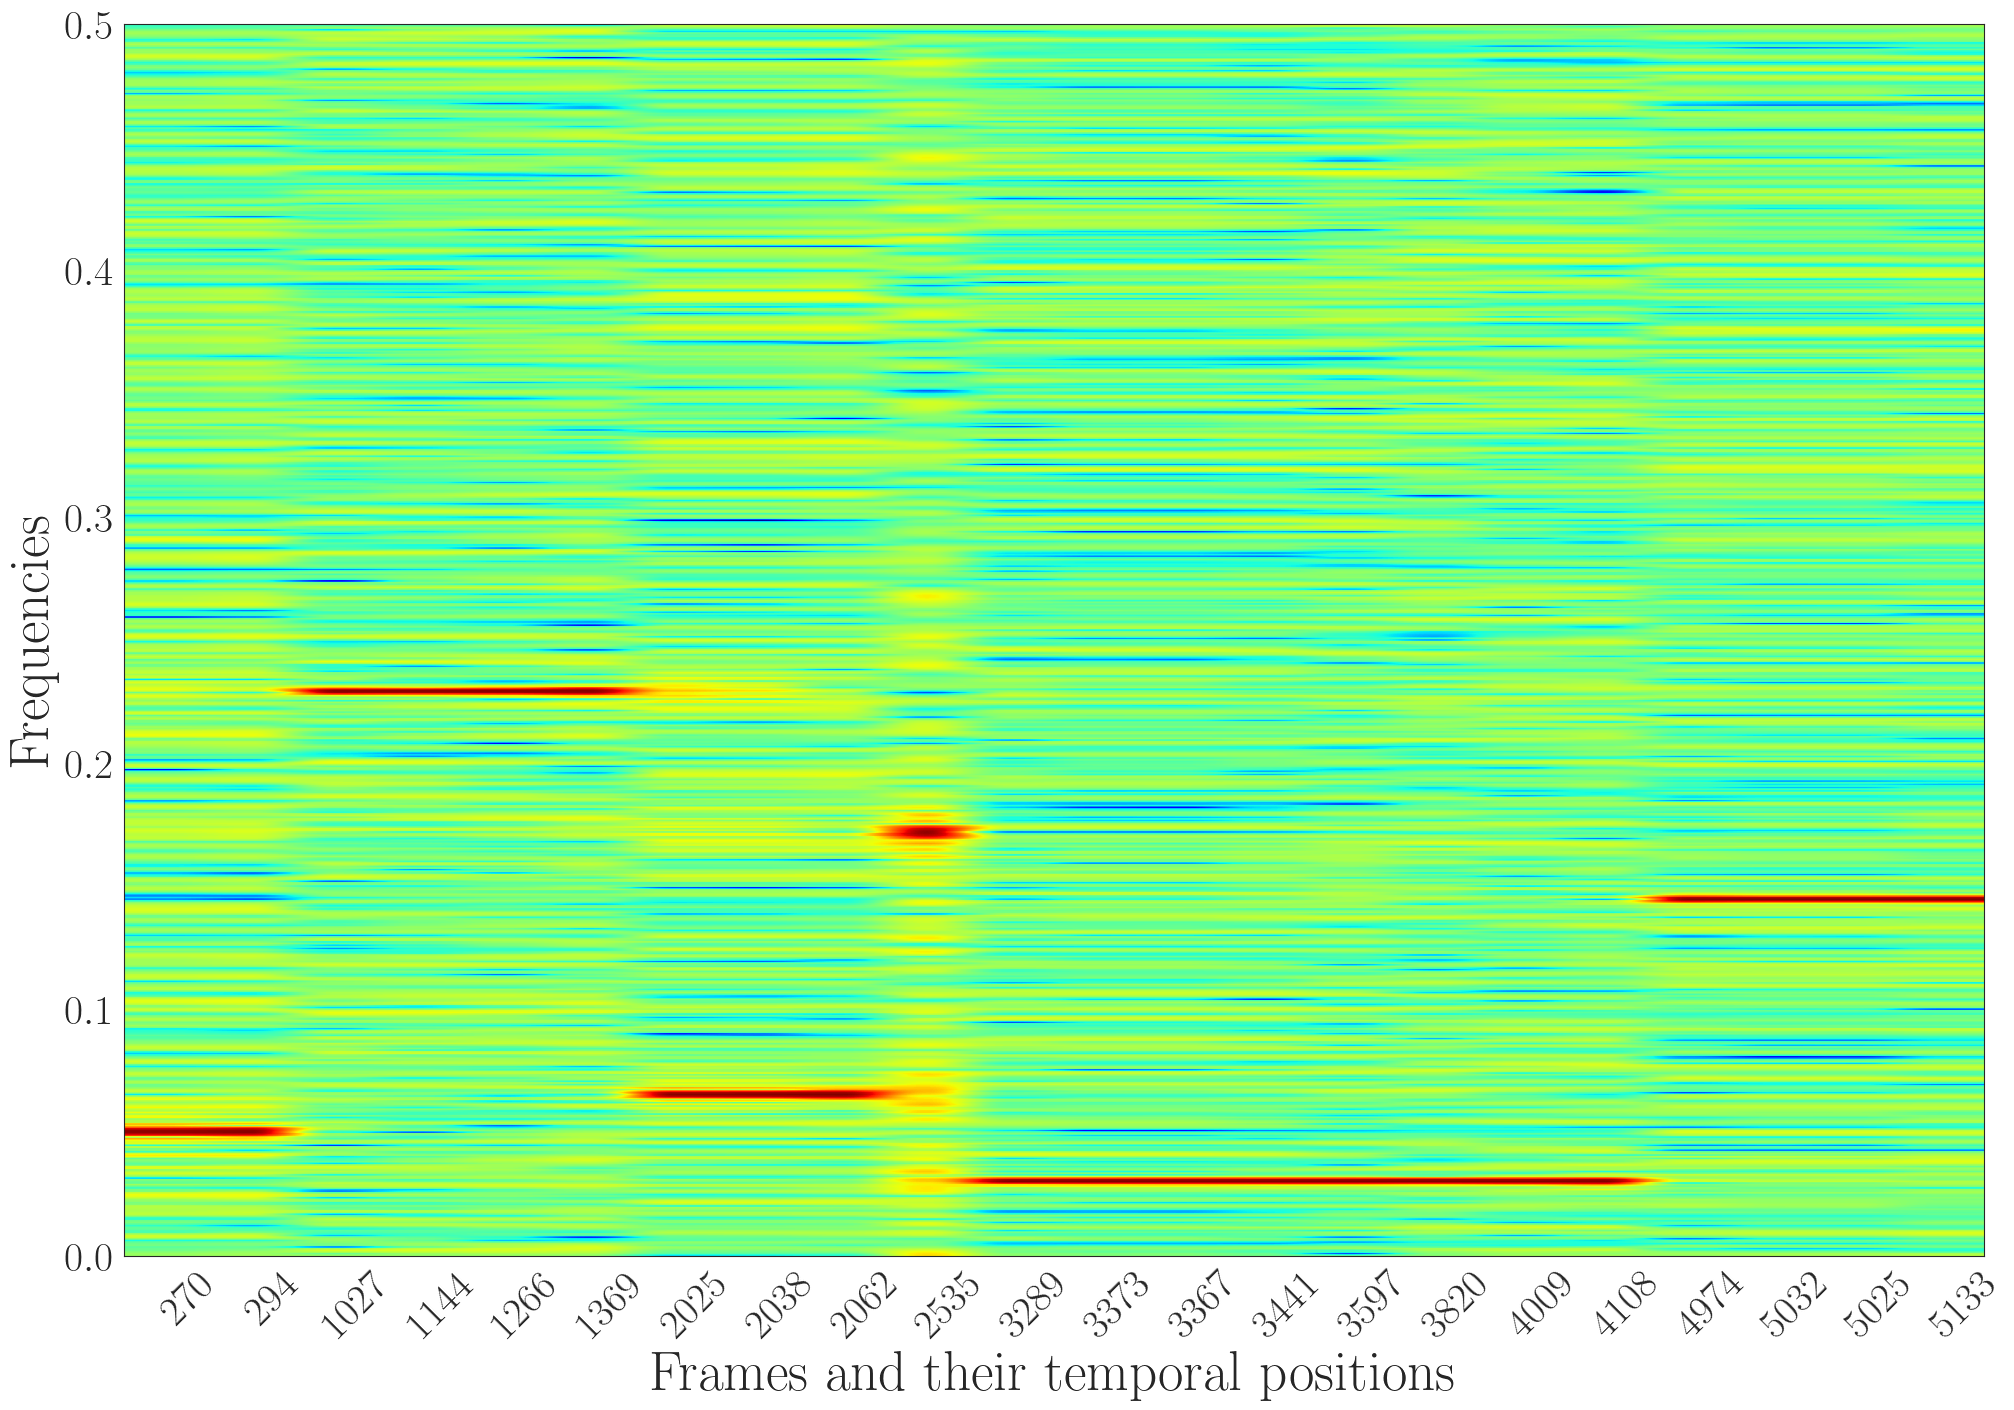

Epoch 1100;	 Err 0.00;	 Kur 21.377;	 Cov 0.00;	 Scales {'kurtosis': 0.0022837321739643812, 'coverage': 0.9977162480354309, 'entropy': 0.0} 
Epoch 1200;	 Err 0.00;	 Kur 21.350;	 Cov 0.00;	 Scales {'kurtosis': 0.0019592237658798695, 'coverage': 0.9980407953262329, 'entropy': 0.0} 
Epoch 1300;	 Err 0.00;	 Kur 21.324;	 Cov 0.00;	 Scales {'kurtosis': 0.001726610236801207, 'coverage': 0.9982733726501465, 'entropy': 0.0} 
Epoch 1400;	 Err 0.00;	 Kur 21.301;	 Cov 0.00;	 Scales {'kurtosis': 0.0015289934817701578, 'coverage': 0.9984710216522217, 'entropy': 0.0} 
Epoch 1500;	 Err 0.00;	 Kur 21.278;	 Cov 0.00;	 Scales {'kurtosis': 0.0013778575230389833, 'coverage': 0.9986221194267273, 'entropy': 0.0} 
Epoch 1600;	 Err 0.00;	 Kur 21.257;	 Cov 0.00;	 Scales {'kurtosis': 0.0012450198410078883, 'coverage': 0.9987549781799316, 'entropy': 0.0} 
Epoch 1700;	 Err 0.00;	 Kur 21.236;	 Cov 0.00;	 Scales {'kurtosis': 0.001131023047491908, 'coverage': 0.998869001865387, 'entropy': 0.0} 
Epoch 1800;	 Err 0.00;	

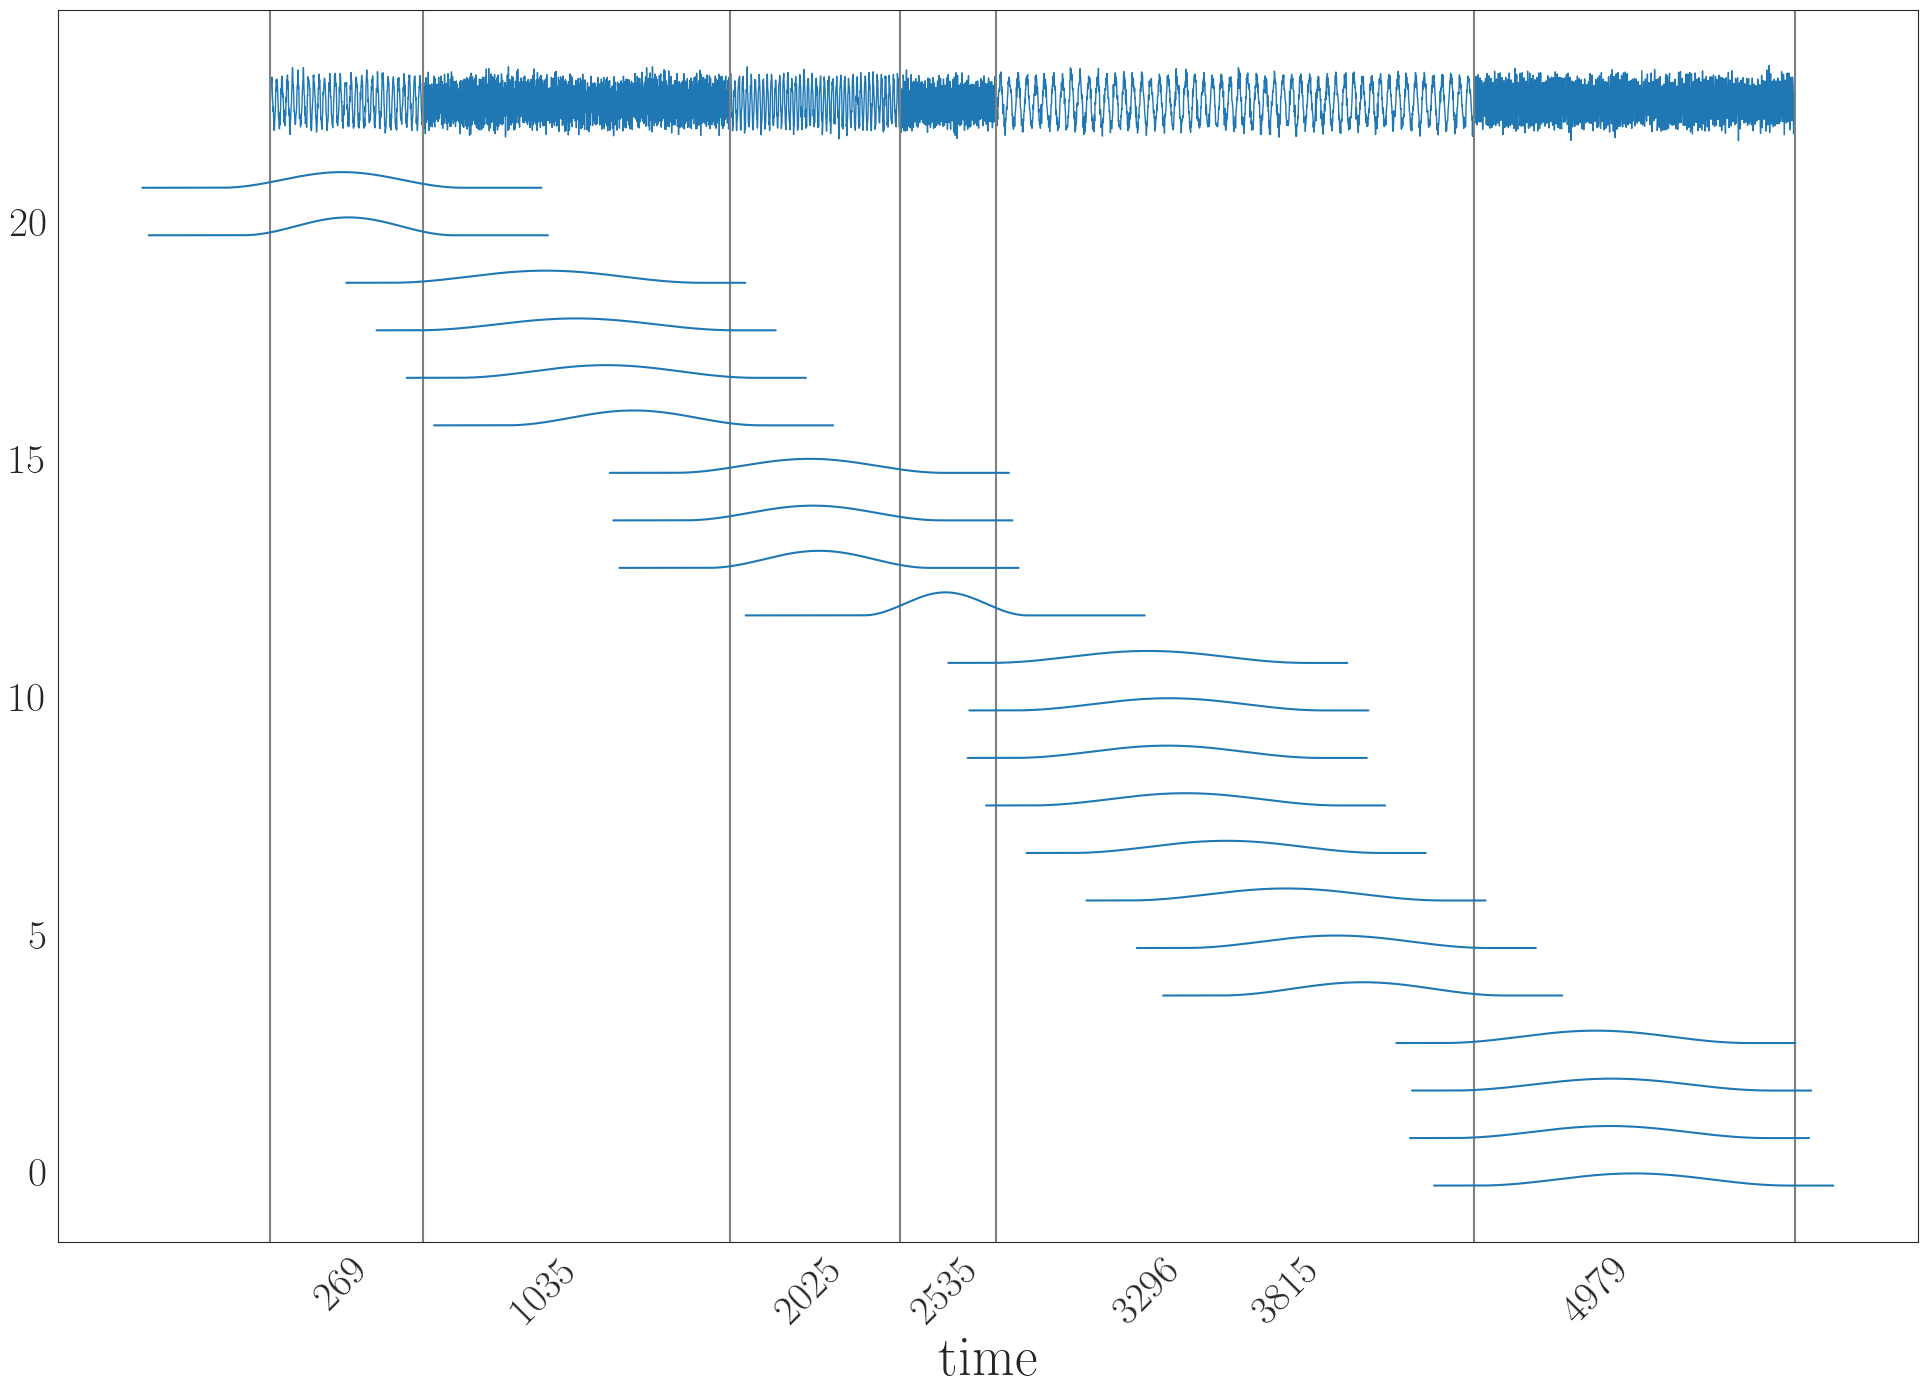

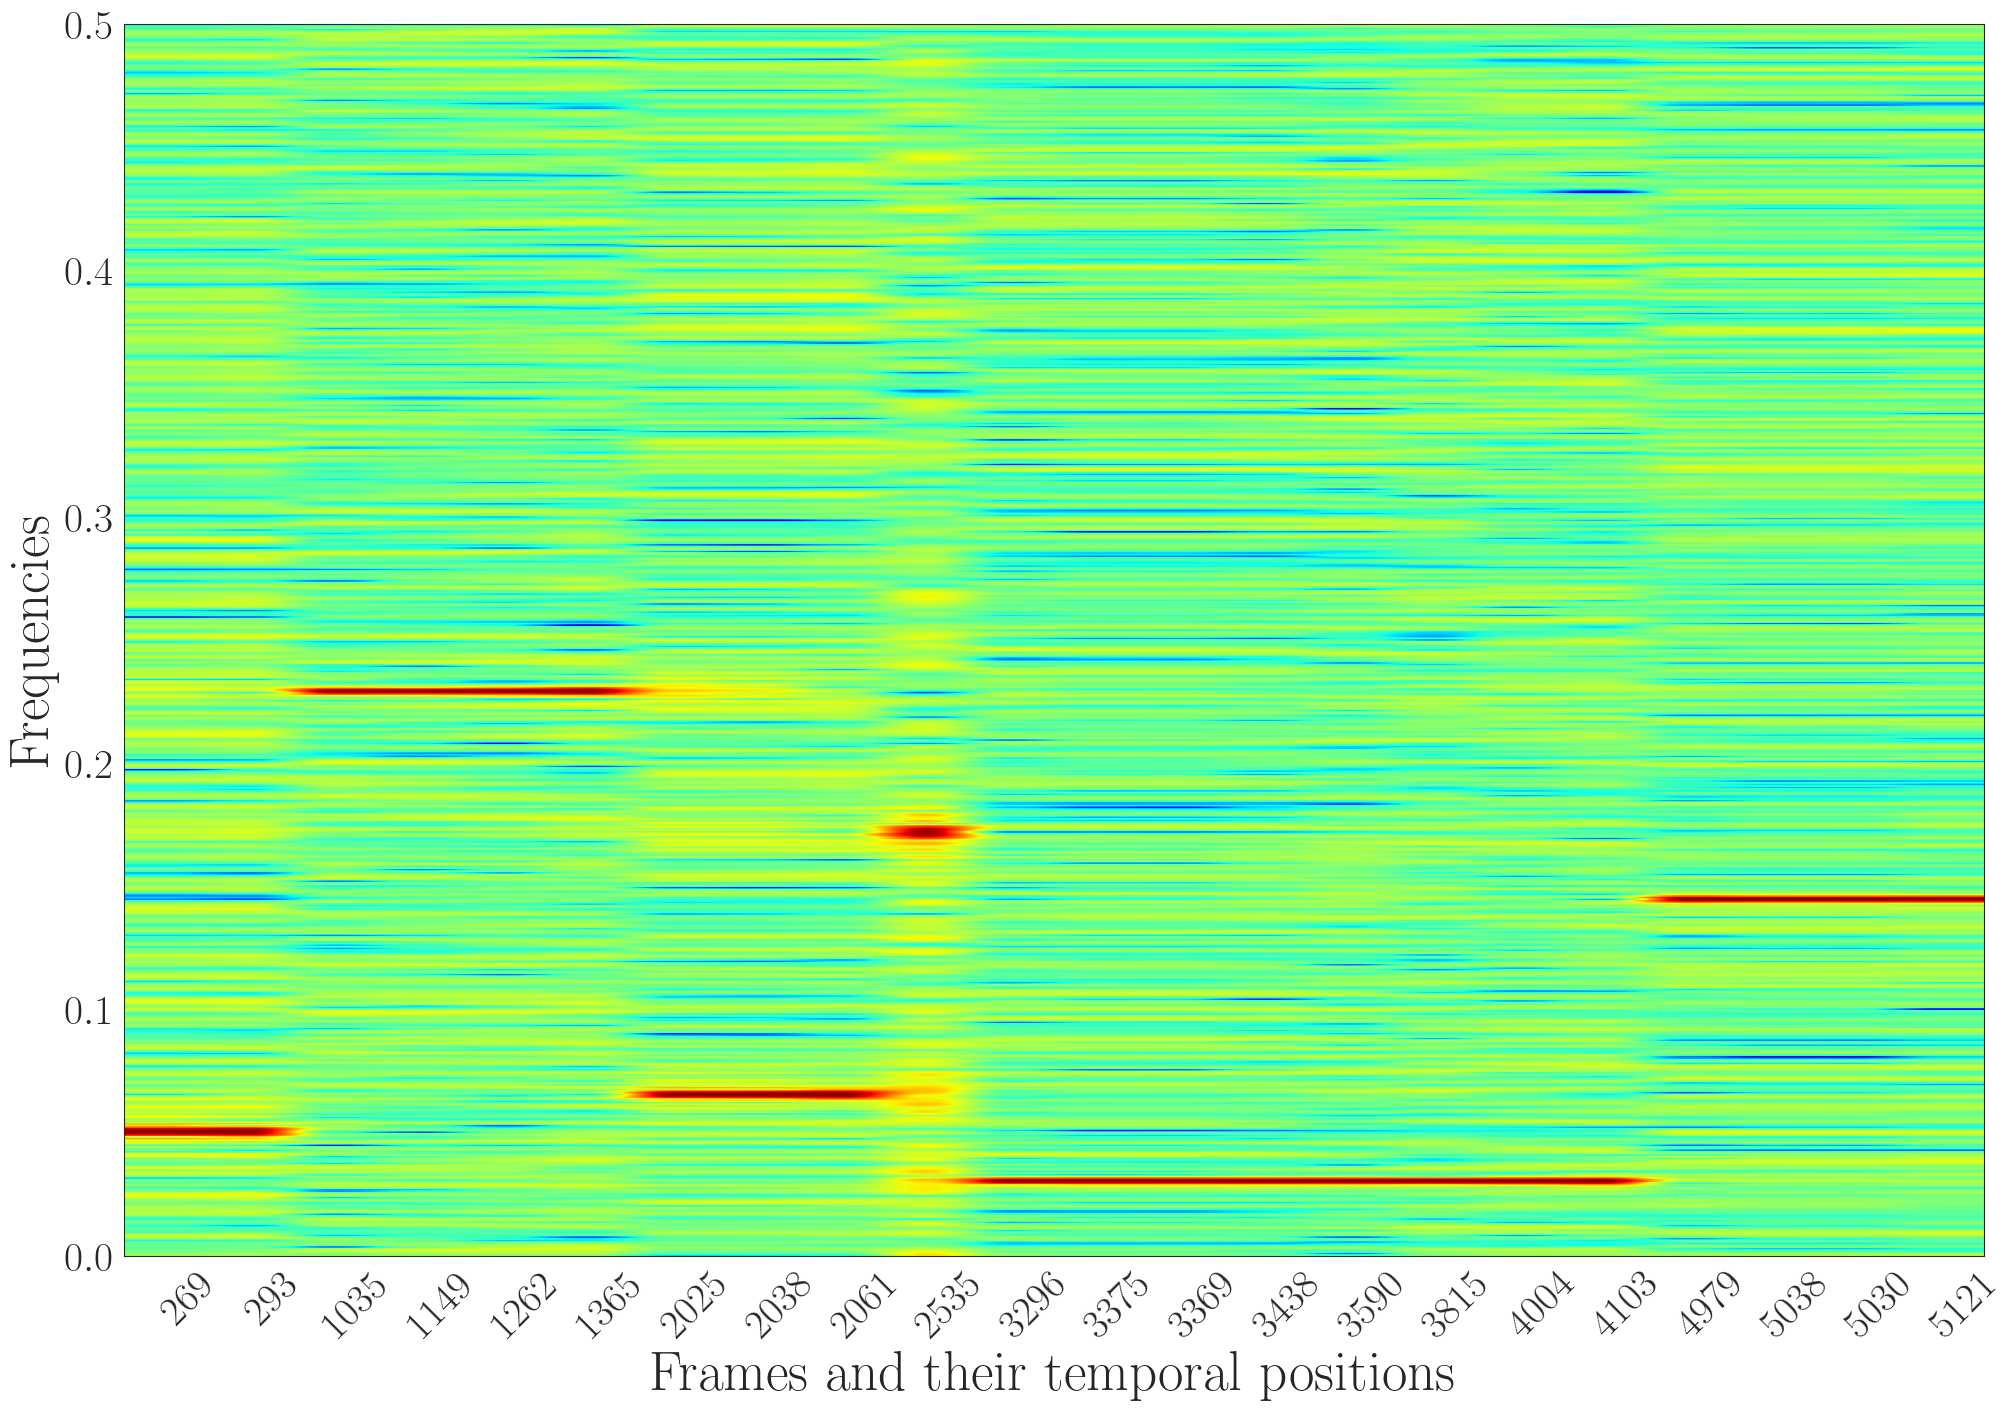

Epoch 2100;	 Err 0.00;	 Kur 21.159;	 Cov 0.00;	 Scales {'kurtosis': 0.0008309283293783665, 'coverage': 0.9991690516471863, 'entropy': 0.0} 
Epoch 2200;	 Err 0.00;	 Kur 21.141;	 Cov 0.00;	 Scales {'kurtosis': 0.0007863619248382747, 'coverage': 0.9992136359214783, 'entropy': 0.0} 
Epoch 2300;	 Err 0.00;	 Kur 21.123;	 Cov 0.00;	 Scales {'kurtosis': 0.0007279638084582984, 'coverage': 0.9992720484733582, 'entropy': 0.0} 
Epoch 2400;	 Err 0.00;	 Kur 21.105;	 Cov 0.00;	 Scales {'kurtosis': 0.0006864890456199646, 'coverage': 0.9993135333061218, 'entropy': 0.0} 


In [9]:
mystft = MySpec(x, 500, 1500, 250)
spec, _ = mystft(x)
dict_loss = mystft.loss(spec)
mystft.print2(spec, dict_loss, mark_list, x) 

#params1 = [ {'params': mystft.win_length, 'lr': 5}]
#params2 = [ {'params': mystft.strides,    'lr': 5}]
#opt1 = torch.optim.RMSprop(params1)
#opt2 = torch.optim.RMSprop(params2)
#sch1 = torch.optim.lr_scheduler.StepLR(optimizer=opt1, step_size=50, gamma=.1, verbose=True) #.ReduceLROnPlateau(optimizer=opt1, mode='min', factor=.1, patience=100, verbose=True)
#sch2 = torch.optim.lr_scheduler.StepLR(optimizer=opt2, step_size=50, gamma=.1, verbose=True) #.ReduceLROnPlateau(optimizer=opt2, mode='min', factor=.1, patience=19, verbose=True)

params = [ {'params': mystft.parameters(),    'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=200, verbose=True) #StepLR(optimizer=opt, step_size=20, gamma=.1, verbose=True) #ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=10, verbose=True)

alpha = 1.0
inter_epoch = 1
win_epoch = 0
epsilon = 0.

min_kur = 1

scale ={}
all_tasks = ['coverage', 'kurtosis', 'entropy']
tasks = ['kurtosis', 'coverage']
for epoch in range(10_000):  

    # Research scales 
    scale = scale_loss(mystft, alpha, epsilon, x, tasks)
    #scale['coverage'] = 0.5
    #scale['entropy'] = 0.5
    for iii in list(set(all_tasks)-set(tasks)):
        scale[iii]= 0.0
    
    for k in range(inter_epoch):
        opt.zero_grad()
        
        
        spec, _ = mystft(x)
        dict_loss = mystft.loss(spec)        
        
        #alphat = mystft.actual_strides[..., 1:] - (mystft.actual_win_length[..., 1:]-mystft.actual_win_length[..., 0:-1])/2        
        #betat = alphat[:, 1:]+alphat[:, :-1]
        #betat = torch.cat((2*alphat[:, 0:1], betat, 2*alphat[:, -1:]), dim=1) 
        #weight = betat/betat.sum()
        #entropy = 1. * (1-  (dict_loss['div_js'] * weight).sum().mean())   
        
        cov = 1. * (1 - dict_loss['cov'].mean()-epsilon).pow(alpha)
        
        alphat = mystft.actual_strides[None, 1:] #- (mystft.actual_win_length[..., 1:]-mystft.actual_win_length[..., 0:-1])/2       
        betat = alphat[:, 1:]+alphat[:, :-1]
        betat = torch.cat((2*alphat[:, 0:1], betat, 2*alphat[:, -1:]), dim=1) 
        weight = betat/betat.sum()
        
        kur =  100 * (weight /dict_loss['kurtosis']).mean()  
        
        #entropy = 1. * (1-  (dict_loss['div_js'] * weight).sum().mean())   
        #win_loss =  50 / mystft.win_length.mean()
        
        err =    scale['kurtosis']*kur #+ scale['entropy']*entropy#+ win_loss # scale['entropy']*entropy  scale['coverage']*cov +
        loss =   kur
        
        err.backward() 
        
        opt.step()
        
        #with torch.no_grad():
        ##mystft.win_length.clamp_(mystft.N/100, mystft.N)
        #mystft.strides[1:].clamp_(0, mystft.N)
        
            
    #if epoch % 1000 == 0:
    #    mystft.print2(spec, dict_loss, mark_list, x, epoch) 
    if epoch % 100 == 0:
        print(f"Epoch {epoch:.0f};\t Err {err:.2f};\t Kur {1_000 * kur:.3f};\t Cov {cov:.2f};\t Scales {scale} ")
    if epoch % 1000 == 0 or epoch == 100:
        mystft.print2(spec, dict_loss, mark_list, x, epoch) 
    #if min_kur >= kur:
    #    min_kur = kur
    #    print(f"Epoch {epoch:.0f};\t Err {err:.2f};\t Entr {entropy:.3f};\t Kur {1000 * kur:.3f};\t Cov {cov:.2f};\t Scales {scale} ")
    
        
    sch.step(loss)
    
    if opt.param_groups[0]['lr'] < .1:
        break
        
    
print('end', min_kur)
spec, _ = mystft(x)
spec = spec.detach()
print(mystft.frames)
mystft.print2(spec, dict_loss, mark_list, x, epoch)

print('end')

In [ ]:
aaa

NameError: name 'aaa' is not defined